# DHCG Tunability Optimization

> Optimizate tunability; defined as distance between peaks divided by average FWHM

Conditions
- SiO2 Thickness under 3um
- Graphene Fermi energy between 0.05eV and 0.6eV
- Si thickness under 1um
- P shorter than wavelength (suppress diffraction)

Optimization Method
- BOBYQA(Bound optimization by quadratic approximation)
- BOBYQA done via nlopt BOBYQA function

In [1]:
import matplotlib.pyplot as plt
import nlopt
from util_n import *
from util_opt import *
from util_meent import *

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
# Optimization wrapper with multiple randomized restarts
def optimize_with_restarts(num_restarts=10):
    best_parameters = None
    best_value = float('inf')  # Start with infinity for minimization
    
    # Define bounds for the variables
    lower_bounds = np.array([2000, 0.01, 1500, 100, 100])
    upper_bounds = np.array([3000, 0.3, 2000, 300, 2000])
    
    for i in range(num_restarts):
        print(f"\nRestart {i+1}/{num_restarts}")
        
        # Initialize BOBYQA optimizer
        dim = 5
        opt = nlopt.opt(nlopt.LN_BOBYQA, dim)
        opt.set_lower_bounds(lower_bounds)
        opt.set_upper_bounds(upper_bounds)
        
        # Define the objective function with progress tracking
        eval_count = 0  # Reset evaluation count for each restart
        def objective_with_progress(parameters, grad):
            nonlocal eval_count, best_value, best_parameters
            # Calculate the current objective value for minimization
            objective_value = -1* tunability(parameters)
            eval_count += 1

            # Track and print progress
            print(f"  Eval {eval_count}: Current parameters = {parameters}, Tunability value = {objective_value}")
            
            # Check and update if a new minimum is found
            if objective_value < best_value and objective_value > -3:
                best_value = objective_value
                best_parameters = parameters.copy()
                print(f"  New best found! Minimum Tunability: {best_value} at parameters {best_parameters}")

            return objective_value  # Return the value for minimization

        # Set the objective function and stopping criteria
        opt.set_min_objective(objective_with_progress)
        opt.set_xtol_rel(5e-3)
        opt.set_maxeval(1000)
        
        # Random starting point within bounds
        x0 = lower_bounds + np.random.rand(dim) * (upper_bounds - lower_bounds)
        
        # Run optimization from the random starting point
        try:
            x_optimal = opt.optimize(x0)
            optimal_value = opt.last_optimum_value()
            
            # Update the best result if found
            if optimal_value < best_value and optimal_value > -3:
                best_value = optimal_value
                best_parameters = x_optimal.copy()
                
            print(f"Optimal parameters from this run: {x_optimal}")
            print(f"Minimum tunability from this run: {optimal_value}\n")
        except Exception as e:
            print(f"Optimization failed at restart {i+1} with error: {e}")

    print("\nOverall Best Parameters:", best_parameters)
    print("Overall Minimum Tunability:", best_value)

    return best_parameters

# Run optimization with multiple restarts
best_parameters = optimize_with_restarts(num_restarts=30)


Restart 1/30


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\meent\on_torch\modeler\modeling.py:76: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)
  lx = lx.type(self.type_float)


  Eval 1: Current parameters = [2.99416910e+03 1.79213640e-01 1.50179004e+03 2.46627143e+02
 2.73962343e+02], Tunability value = 0.04856192424718013
  New best found! Minimum Tunability: 0.04856192424718013 at parameters [2.99416910e+03 1.79213640e-01 1.50179004e+03 2.46627143e+02
 2.73962343e+02]
  Eval 2: Current parameters = [2.99854228e+03 1.79213640e-01 1.50179004e+03 2.46627143e+02
 2.73962343e+02], Tunability value = 0.18834106208945456
  Eval 3: Current parameters = [2.99416910e+03 2.51713640e-01 1.50179004e+03 2.46627143e+02
 2.73962343e+02], Tunability value = -0.11554447582198414
  New best found! Minimum Tunability: -0.11554447582198414 at parameters [2.99416910e+03 2.51713640e-01 1.50179004e+03 2.46627143e+02
 2.73962343e+02]
  Eval 4: Current parameters = [2.99416910e+03 1.79213640e-01 1.50313258e+03 2.46627143e+02
 2.73962343e+02], Tunability value = -0.03279202739604966
  Eval 5: Current parameters = [2.99416910e+03 1.79213640e-01 1.50179004e+03 2.96627143e+02
 2.739623

In [6]:
p = torch.tensor(best_parameters[0], requires_grad=True, dtype=torch.float64)
delta = torch.tensor(best_parameters[1], requires_grad=True, dtype=torch.float64)
d = torch.tensor(best_parameters[2], requires_grad=True, dtype=torch.float64)
t = torch.tensor(best_parameters[3], requires_grad=True, dtype=torch.float64)
w = torch.tensor(best_parameters[4], requires_grad=True, dtype=torch.float64)

print(p,t,w,delta,d)

tensor(2126.5230, dtype=torch.float64, requires_grad=True) tensor(159.2564, dtype=torch.float64, requires_grad=True) tensor(1864.4868, dtype=torch.float64, requires_grad=True) tensor(0.1239, dtype=torch.float64, requires_grad=True) tensor(1916.5317, dtype=torch.float64, requires_grad=True)


In [7]:
p = torch.round(p, decimals=-1)
t = torch.round(t)
w = torch.round(w, decimals= -1)
d = torch.round(d, decimals = -1)
delta = torch.round(delta, decimals = 3)
        
period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

print(p,t,w,delta,d)

print("p: ", p.item())
print("delta: ", delta.item())
print("d: ", d.item())
print("t: ", t.item())
print("w: ", w.item())

tensor(2130., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(159., dtype=torch.float64, grad_fn=<RoundBackward0>) tensor(1860., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(0.1240, dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(1920., dtype=torch.float64, grad_fn=<RoundBackward1>)
p:  2130.0
delta:  0.124
d:  1920.0
t:  159.0
w:  1860.0


In [8]:
wavelengths = torch.linspace(target_wl-500, target_wl+500, 500) 
    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances_after_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_005eV[i] = de_ri.sum()

reflectances_after_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_060eV[i] = de_ri.sum()


y_005_af = reflectances_after_005eV.detach().numpy()
y_060_af = reflectances_after_060eV.detach().numpy()

In [9]:
delta = torch.tensor(0.00, requires_grad=True, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

reflectances_0del_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_005eV[i] = de_ri.sum()

    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances_0del_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_060eV[i] = de_ri.sum()

x_np = wavelengths.numpy()
y_005_0del = reflectances_0del_005eV.detach().numpy()
y_060_0del = reflectances_0del_060eV.detach().numpy()

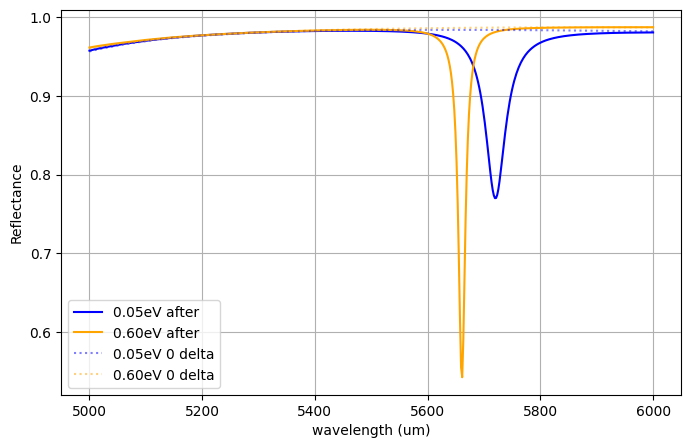

In [10]:
# Plotting with matplotlib
plt.figure(figsize=(8, 5))
plt.plot(x_np, y_005_af, label='0.05eV after', color='blue')
plt.plot(x_np, y_060_af, label='0.60eV after',color='orange')
plt.plot(x_np, y_005_0del, label='0.05eV 0 delta', color='blue', ls = ':', alpha = 0.5)
plt.plot(x_np, y_060_0del, label='0.60eV 0 delta', color='orange', ls = ':', alpha = 0.5)
plt.xlabel('wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

plt.show()